## List of tables:
### 1. [Table 8: Treatment effects on quantity](#quantity)

## List of figures:
### 2. [Figure 6: Distribution of fragments submitted](#icdf)

#### Imports libraries

In [1]:
import matplotlib.pyplot as plt  # Plotting
import numpy as np  # Matrix algebra
import os  # File system handling
import pandas as pd  # Dataframe handling
import statsmodels.formula.api as smf  # Regressions analysis

from matplotlib.ticker import FuncFormatter  # Formatting graphs
from scipy import stats  # Statistics module
from statsmodels.iolib.summary2 import summary_col  # Regression output table
from statsmodels.stats.anova import anova_lm  # Regression anova table
from statsmodels.stats.multicomp import MultiComparison  # Multi-comparison tests

#### Set project directory

In [2]:
PROJECT_FOLDER = os.path.dirname(os.path.dirname(os.getcwd()))
FINAL_DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data', 'final')
TABLES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'tables')
FIGURES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'figures')

#### Pandas options

In [3]:
pd.set_option("display.precision", 3)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_rows", 40)

#### Set plotting style

In [4]:
plt.style.use('classic')

#### Set plotting properties 

In [5]:
bar_kw = dict(kind='bar', color='0.4', alpha=0.8, lw=0.5, width=0.7)
line_kw = dict(kind='line', lw=1, alpha=1, legend=True)
font_kw = dict(fontsize=11, color='k')
grid_kw = dict(linewidth=1, axis="y", zorder=2, antialiased=True)
xlab_kw = dict(fontsize=11, labelpad=3)
ylab_kw = dict(fontsize=11, labelpad=3)
error_kw = dict(elinewidth=2, ecolor='0.15')
legend_kw = dict(frameon=False)
tick_kw = dict(
    size=5,
    which='both',
    direction='out',
    right=False,
    top=False,
    labelbottom=True
)

#### Retrieving dataframe

In [6]:
DATA = os.path.join(
    FINAL_DATA_FOLDER, 
    'experiment_2',                
    'data_final.feather'
)

df = pd.read_feather(DATA)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Columns: 596 entries, Age to Q110_timer
dtypes: datetime64[ns](2), float64(309), int64(26), object(259)
memory usage: 8.0+ MB


#### Group datasets according to treatments

In [7]:
grouped_all = df.groupby('Treatment_str')
grouped_first = df.groupby('Goal')
grouped_second = df.groupby('Charisma')

#### Define treatment index for ordering

In [8]:
treat_index = [
    'Neutral', 
    'Charisma without goal', 
    'Goal', 
    'Full charisma'
]

#### Histogram for number of sentences submitted  <a id='histogram_counter_real'></a>



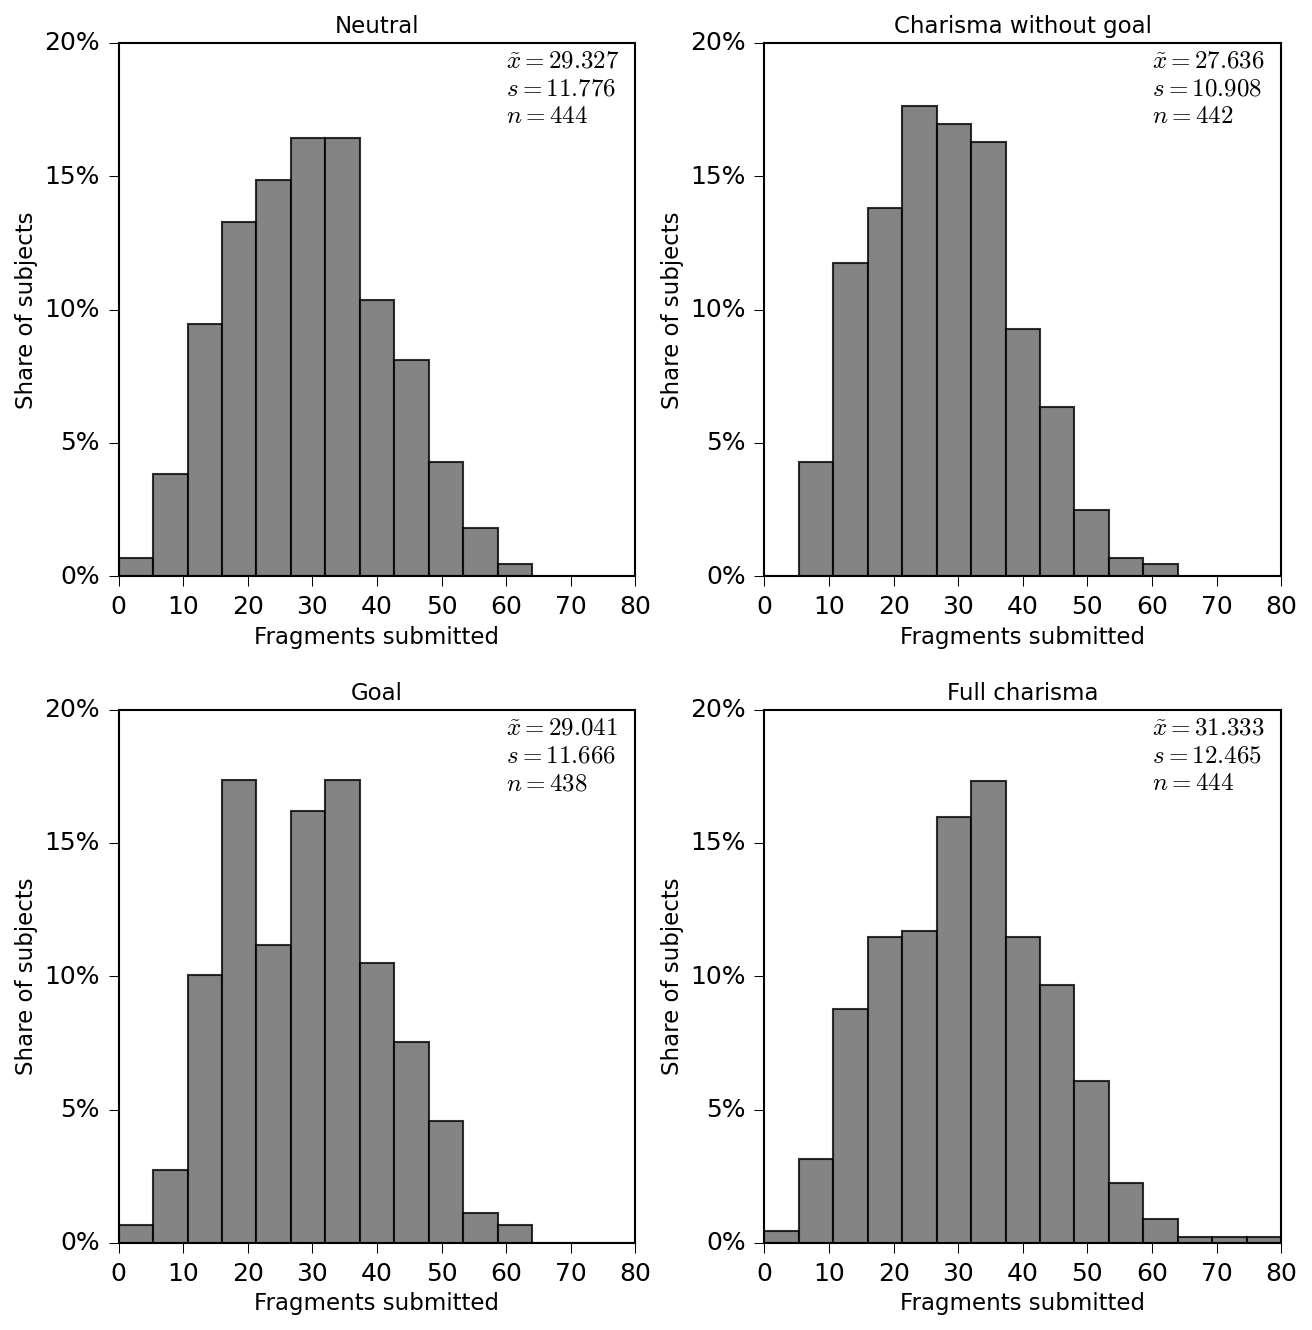

In [9]:
hist_params = dict(bins=15, range=(0, 80),  color='0.4', alpha=0.8) 
fig, _ = plt.subplots(2, 2, sharey=False, figsize=(10, 10), dpi=150, facecolor='w')
fig.subplots_adjust(hspace=0.25, wspace=0.25)
for i, ax in enumerate(fig.axes):
    counter = df[df['Treatment_str'] == treat_index[i]]['Counter_real']
    counter.hist(ax=ax, weights=np.ones(len(counter)) / len(counter), **hist_params)
    ax.set_title(treat_index[i], **font_kw)
    ax.set_ylim(0, 0.2)
    ax.grid(False)
    ax.tick_params(**tick_kw)
    ax.set_xlabel("Fragments submitted", **xlab_kw)
    ax.set_ylabel("Share of subjects", **ylab_kw)
    ax.yaxis.set_major_formatter(FuncFormatter('{:.0%}'.format))
    mean, std, count = counter.mean(), counter.std(), counter.count()
    ax.text(60, 0.17 , f"$\~{{x}}={mean:.3f}$\n$s={std:.3f}$\n$n={count:.0f}$")

path = os.path.join(FIGURES_FOLDER, 'experiment_2', 'counter_real_hist_2.pdf')
fig.savefig(path, bbox_inches='tight')

#### Share of workers at or above production target (more or equal to 33 submissions):

In [10]:
df.groupby('Treatment_str')['Counter_real']\
    .apply(lambda x: len(x[x >= 33]) / len(x))\
    .to_frame()\
    .rename_axis('Treatment')\
    .rename({'Counter_real': 'Share of workers above target output'}, axis=1)

,Share of workers above target output
Treatment,
Charisma without goal,0.321
Full charisma,0.453
Goal,0.386
Neutral,0.387


####  Plotting inverse cumulative distribution function for fragments submitted <a id='icdf'></a>

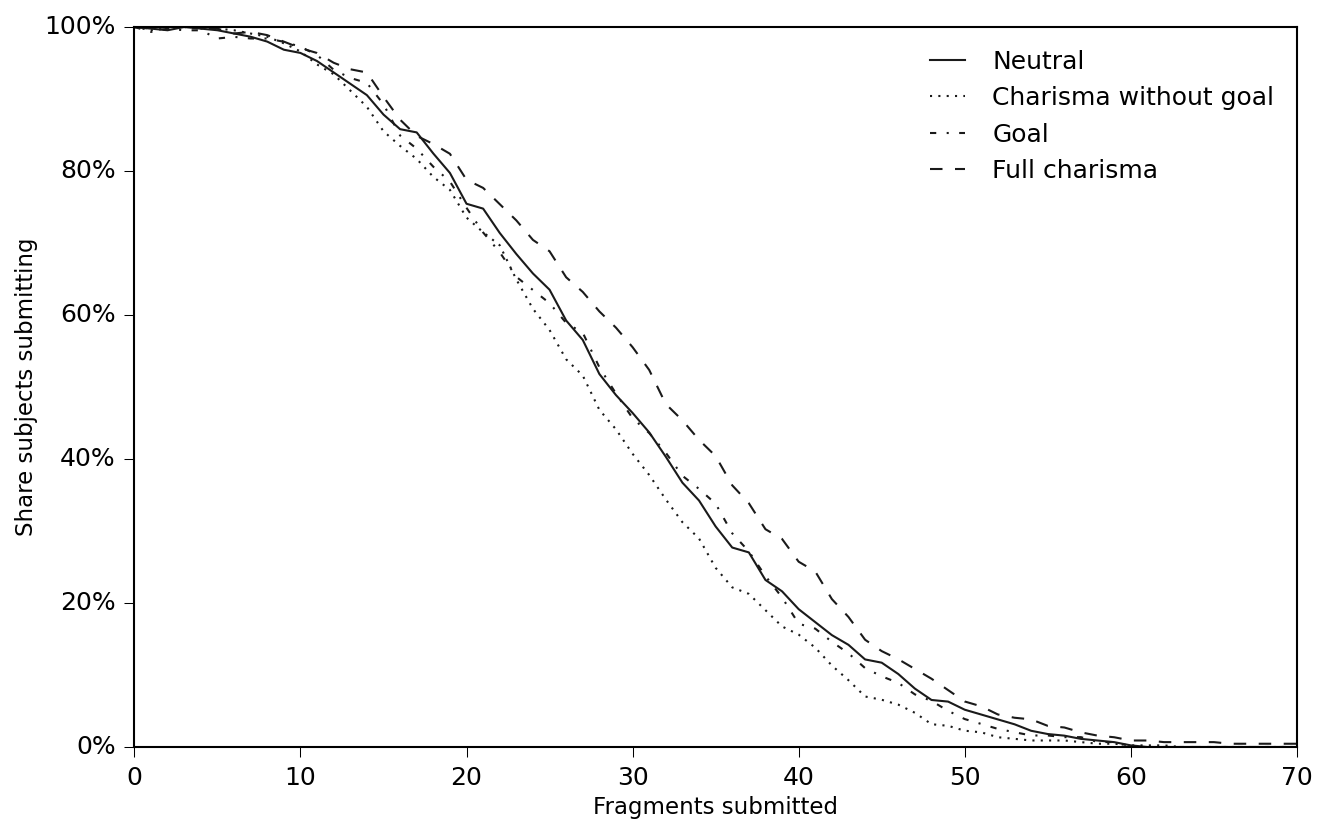

In [11]:
columns = [f'Q{x}_answer' for x in range(1, df['Counter_real'].max() + 1)]

df_counter = grouped_all[columns]\
    .count()\
    .transpose()\
    .rename_axis('Question_answer', axis=1)\
    .reset_index(drop=True)\
    .sort_index(axis=1, ascending=False)\
    .apply(lambda x: x/x.loc[0], axis=0)\
    .reindex(treat_index, axis=1)

fig, ax = plt.subplots(figsize=(10, 6), dpi=150, facecolor='w')
df_counter.plot(ax=ax, color='0.1', style=['-', ':', '-.', '--'])
ax.tick_params(**tick_kw)
ax.set_xlabel("Fragments submitted", **xlab_kw)
ax.set_ylabel("Share subjects submitting", **ylab_kw)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set_ylim(0.0, 1.0)
ax.set_xlim(0.0, 70)
ax.legend(frameon=False, shadow=True, fontsize='medium')

path = os.path.join(FIGURES_FOLDER, 'experiment_2', 'icdf_2.pdf')
fig.savefig(path, bbox_inches='tight')

#### Pairwise sample distribution comparisson test for number of fragments submitted

In [12]:
mct = MultiComparison(df['Counter_real'], df['Treatment_str'])
mct.allpairtest(stats.ks_2samp, method='Holm')[0]

group1,group2,stat,pval,pval_corr,reject
Charisma without goal,Full charisma,0.1559,0.0,0.0002,True
Charisma without goal,Goal,0.0891,0.0556,0.1668,False
Charisma without goal,Neutral,0.0681,0.2406,0.4811,False
Full charisma,Goal,0.0969,0.029,0.1452,False
Full charisma,Neutral,0.0946,0.0376,0.1503,False
Goal,Neutral,0.0357,0.927,0.927,False


#### Cross tabulate average number of fragments submitted

In [13]:
counter_cross = pd.crosstab(
    df['Goal'],
    df['Charisma'],
    values= df['Counter_real'],
    aggfunc='mean',
    margins=True
)\
.rename({0:'No', 1:'Yes'}, axis=0)\
.rename({0:'No', 1:'Yes'}, axis=1)\

counter_cross

Charisma,No,Yes,All
Goal,,,
No,29.327,27.636,28.483
Yes,29.041,31.333,30.195
All,29.185,29.489,29.337


#### Compare average number of fragments submitted, first dimension

In [14]:
counter_first = grouped_first['Counter_real']\
    .agg(['mean', 'sem', 'count'])\
    .rename({0: 'No', 1:'Yes'}, axis=0)

counter_first

,mean,sem,count
Goal,,,
No,28.483,0.382,886
Yes,30.195,0.408,882


#### Pairwise T-test of mean differences for number of fragments submitted, first dimension

In [15]:
mct = MultiComparison(df['Counter_real'], df['Treatment_str'])
mct.allpairtest(stats.ttest_ind, method='Holm')[0]

group1,group2,stat,pval,pval_corr,reject
Charisma without goal,Full charisma,-4.6978,0.0,0.0,True
Charisma without goal,Goal,-1.846,0.0652,0.1305,False
Charisma without goal,Neutral,-2.2169,0.0269,0.0807,False
Full charisma,Goal,2.8189,0.0049,0.0246,True
Full charisma,Neutral,2.466,0.0139,0.0554,False
Goal,Neutral,-0.3617,0.7177,0.7177,False


#### Pairwise variance comparison test for number of fragments submitted, first dimension

In [16]:
mct.allpairtest(stats.levene, method='Holm')[0]

group1,group2,stat,pval,pval_corr,reject
Charisma without goal,Full charisma,7.3682,0.0068,0.0406,True
Charisma without goal,Goal,3.3693,0.0668,0.3338,False
Charisma without goal,Neutral,2.4875,0.1151,0.4605,False
Full charisma,Goal,0.9052,0.3417,0.7503,False
Full charisma,Neutral,1.3245,0.2501,0.7503,False
Goal,Neutral,0.0497,0.8237,0.8237,False


#### Plot average number of fragments submitted, first treatment dimension

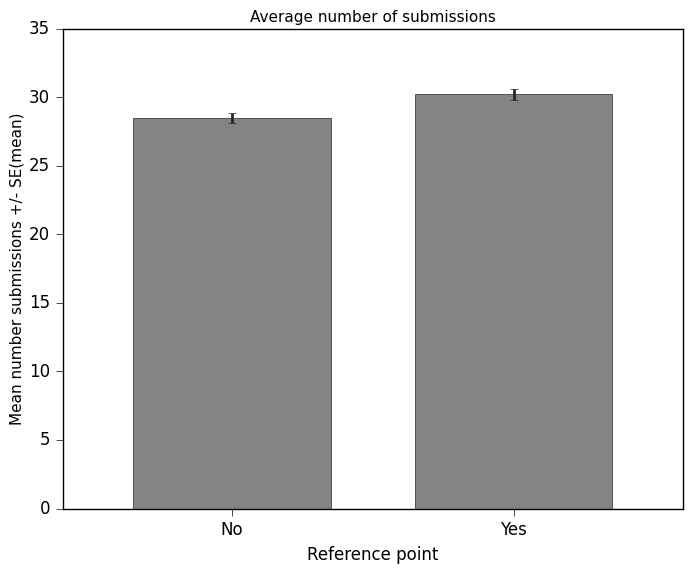

In [17]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100, facecolor='w')
counter_first['mean'].plot(yerr=counter_first['sem'], ax=ax, error_kw=error_kw, **bar_kw)
ax.set_title('Average number of submissions', **font_kw)
ax.set_ylabel("Mean number submissions +/- SE(mean)", **ylab_kw)
ax.set_xlabel("Reference point")
ax.set_ylim(0, 35)
ax.tick_params(rotation = 0, **tick_kw)

path = os.path.join(
    FIGURES_FOLDER, 
    'experiment_2', 
    'counter_real_first.pdf'
)
plt.savefig(path, bbox_inches='tight')

#### Compare average number of fragments submitted, second dimension

In [18]:
counter_second = grouped_second['Counter_real']\
    .agg(['mean', 'sem', 'count'])\
    .rename({0: 'No', 1:'Yes'}, axis=0)

counter_second

,mean,sem,count
Charisma,,,
No,29.185,0.394,882
Yes,29.489,0.398,886


####  Pairwise T-test of mean differences for number of fragments submitted, second dimension

In [19]:
mct = MultiComparison(df['Counter_real'], df['Treatment_str'])
mct.allpairtest(stats.ttest_ind, method='Holm')[0]

group1,group2,stat,pval,pval_corr,reject
Charisma without goal,Full charisma,-4.6978,0.0,0.0,True
Charisma without goal,Goal,-1.846,0.0652,0.1305,False
Charisma without goal,Neutral,-2.2169,0.0269,0.0807,False
Full charisma,Goal,2.8189,0.0049,0.0246,True
Full charisma,Neutral,2.466,0.0139,0.0554,False
Goal,Neutral,-0.3617,0.7177,0.7177,False


####  Pairwise variance comparisson test for number of fragments submitted, second dimension

In [20]:
mct.allpairtest(stats.levene, method='Holm')[0]

group1,group2,stat,pval,pval_corr,reject
Charisma without goal,Full charisma,7.3682,0.0068,0.0406,True
Charisma without goal,Goal,3.3693,0.0668,0.3338,False
Charisma without goal,Neutral,2.4875,0.1151,0.4605,False
Full charisma,Goal,0.9052,0.3417,0.7503,False
Full charisma,Neutral,1.3245,0.2501,0.7503,False
Goal,Neutral,0.0497,0.8237,0.8237,False


#### Plot average number of submissions, second treatment dimension

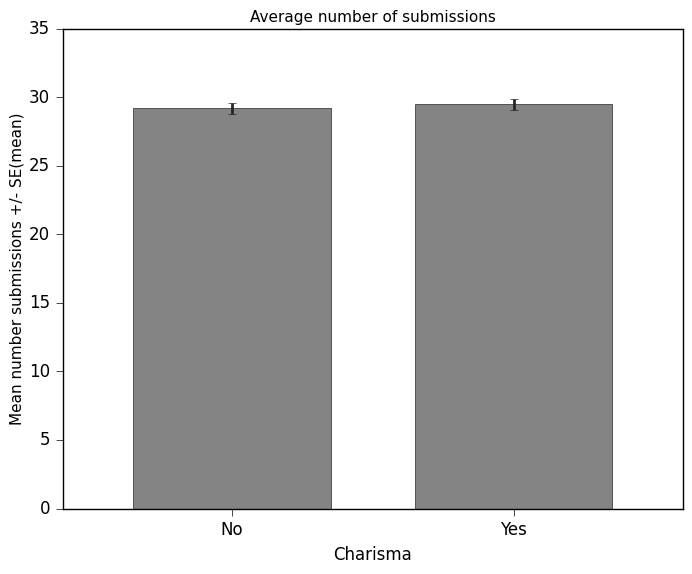

In [21]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100, facecolor='w')
ax.set_title('Average number of submissions', **font_kw)
counter_second['mean'].plot(yerr=counter_second['sem'], ax=ax, error_kw=error_kw, **bar_kw)
ax.tick_params(rotation = 0, **tick_kw)
ax.set_ylabel("Mean number submissions +/- SE(mean)", **ylab_kw)
ax.set_xlabel("Charisma")
ax.set_ylim(0, 35)

path = os.path.join(
    FIGURES_FOLDER, 
    'experiment_2', 
    'counter_real_second.pdf'
)
fig.savefig(path, bbox_inches='tight')

#### Table 8: Treatment effects on quantity <a id='quantity'></a>

In [22]:
regs = {}
regs['reg1'] = 'Counter_real ~ Charisma + Goal'
regs['reg2'] = 'Counter_real ~ Charisma * Goal'
regs['reg3'] = regs['reg2'] + ' + Age + Female + Diverse + Education + Mobile_device'
regs['reg4'] = regs['reg3'] + ' + C(Group)'

ols_results = [smf.ols(formula=v, data=df).fit(cov_type='HC1') for v in regs.values()]    

order = [
    'Goal',
    'Charisma',
    'Charisma:Goal',
    'Age',
    'Female',
    'Diverse',
    'Education',
    'Mobile_device',
    'Intercept',
]

hypotheses_1 = 'Goal + Charisma:Goal'
hypotheses_2 = 'Charisma + Charisma:Goal'
hypotheses_3 = 'Charisma + Goal + Charisma:Goal'

auxiliary = {
    'N': lambda x: f'{x.nobs:.0f}',
    'F': lambda x: f'{x.fvalue:.3f}', 
    'P(>F)': lambda x: f'{x.f_pvalue:.3f}',
    'Charisma*Goal': lambda x: f'{x.t_test(hypotheses_1).effect[0]:.3f}' if x.df_model > 2 else None,
    'std(Charisma*Goal)': lambda x: f'({x.t_test(hypotheses_1).sd[0][0]:.3f})' if x.df_model > 2 else None,
    'Charisma + Charisma*Goal': lambda x: f'{x.t_test(hypotheses_2).effect[0]:.3f}' if x.df_model > 2 else None,
    'std(Charisma + Charisma*Goal)': lambda x: f'({x.t_test(hypotheses_2).sd[0][0]:.3f})' if x.df_model > 2 else None,
    'Goal + Charisma*Goal': lambda x: f'{x.t_test(hypotheses_3).effect[0]:.3f}' if x.df_model > 2 else None,
    'std(Goal + Charisma*Goal)': lambda x: f'({x.t_test(hypotheses_3).sd[0][0]:.3f})' if x.df_model > 2 else None,
}

ols_quant = summary_col(
    ols_results,
    stars=True,
    info_dict=auxiliary,
    float_format='%.3f',
    regressor_order=order,
    drop_omitted=True
)

ols_quant = ols_quant\
    .tables[0]\
    .rename(mapper=lambda x: x.replace('_', ' ').replace(':', ' * '), axis=0)\
    .rename(mapper=lambda x: x.split()[0].replace('Counter_real', 'No. fragments'), axis=1)\
    .rename_axis('Dependent variable:', axis=1)

ols_quant.loc['Group intercepts'] = pd.Series(3*['No'] + 1*['Yes'], index=ols_quant.columns)

ols_quant.to_latex(
    os.path.join(TABLES_FOLDER, 'experiment_2', 'ols_quantity.tex'),
    bold_rows=False,
    float_format="%.3f"
)
ols_quant

Dependent variable:,No. fragments,No. fragments,No. fragments,No. fragments
Goal,1.711***,-0.285,0.292,0.252
,(0.559),(0.789),(0.746),(0.741)
Charisma,0.296,-1.691**,-1.551**,-1.654**
,(0.559),(0.763),(0.731),(0.732)
Charisma * Goal,,3.983***,3.507***,3.585***
,,(1.115),(1.064),(1.065)
Age,,,-0.204***,-0.202***
,,,(0.022),(0.022)
Female,,,1.839***,1.870***
,,,(0.535),(0.532)


#### Post-regression ANOVA 

In [23]:
anova_lm(*ols_results, robust='hc1')

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1765.0,243962.938,0.0,NaN,NaN,NaN
1,1764.0,242209.929,1.0,1753.009,14.271,1.636e-04
2,1759.0,220004.418,5.0,22205.510,36.154,2.455e-35
3,1745.0,214354.428,14.0,5649.990,3.285,3.314e-05


### Estimating linear combinations

In [24]:
formula = 'Counter_real ~ Charisma * Goal'
ols = smf.ols(formula=formula, data=df).fit(cov_type='HC1')

#### Effect of goal when charisma is present

In [25]:
hypotheses = 'Goal + Charisma:Goal'
ols.t_test(hypotheses).summary()

,coef,std err,z,P>|z|,[0.025,0.975]
c0,3.6976,0.787,4.699,0.000,2.155,5.240


#### Effect of charisma when goal is present

In [26]:
hypotheses = 'Charisma + Charisma:Goal'
ols.t_test(hypotheses).summary()

,coef,std err,z,P>|z|,[0.025,0.975]
c0,2.2922,0.813,2.820,0.005,0.699,3.885


#### Effect of full charisma

In [27]:
hypotheses = 'Charisma + Goal + Charisma:Goal'
ols.t_test(hypotheses).summary()

,coef,std err,z,P>|z|,[0.025,0.975]
c0,2.0068,0.814,2.466,0.014,0.412,3.602


#### Convert to html

In [28]:
!jupyter nbconvert --output-dir='./docs' --to html 4_treatment_effects_quantity.ipynb

[NbConvertApp] Converting notebook 4_treatment_effects_quantity.ipynb to html
[NbConvertApp] Writing 970542 bytes to docs/4_treatment_effects_quantity.html
